In [11]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy import signal
from matplotlib import cm
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, trigger_onset

In [12]:
data_directory = '../../../data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed'
mseed_file = f'{data_directory}'
st = read(mseed_file)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-01-19T00:00:00.665000Z - 1970-01-20T00:00:02.778208Z | 6.6 Hz, 572415 samples

In [13]:
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

In [14]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

In [15]:
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

C:\Users\hombr\AppData\Local\Temp\ipykernel_33136\926705533.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


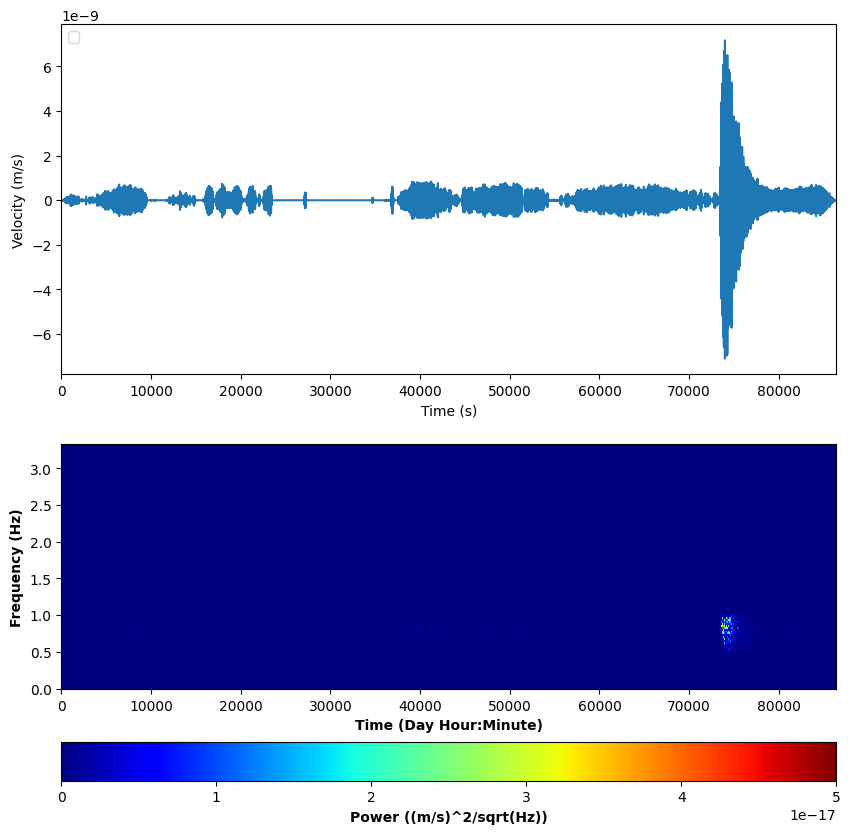

In [16]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

ax.legend(loc='upper left')
# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

c:\Users\hombr\AppData\Local\Programs\Python\Python312\Lib\site-packages\obspy\signal\filter.py:62: UserWarning: Selected high corner frequency (5.0) of bandpass is at or above Nyquist (3.3125). Applying a high-pass instead.
  warnings.warn(msg)


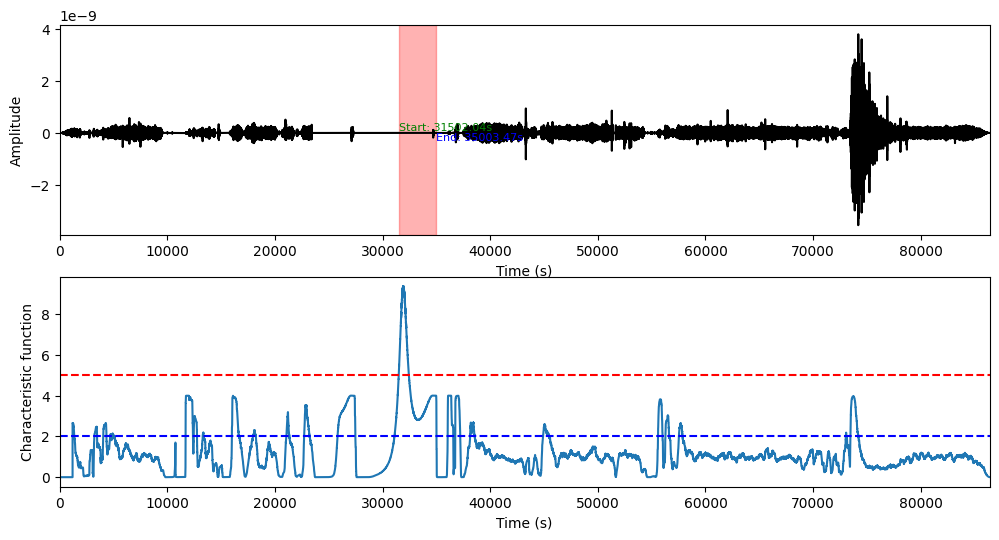

In [17]:
from obspy.signal.trigger import classic_sta_lta, trigger_onset
import matplotlib.pyplot as plt
import numpy as np

# Trace sampling frequency
df = tr.stats.sampling_rate

# Apply a bandpass filter before the analysis (optional)
tr.filter('bandpass', freqmin=1.0, freqmax=5.0)  # Adjust the bandpass filter

# STA/LTA window lengths in seconds (adjusted)
sta_len = 300   # Short-term window, decreased to improve sensitivity to rapid changes
lta_len = 1200  # Long-term window, increased to smooth the long-term response

# Execute classic STA/LTA
cft = classic_sta_lta(tr.data, int(sta_len * df), int(lta_len * df))

# Define thresholds for detection (adjusted)
threshold_on = 5.0  # Increase the activation threshold
threshold_off = 2.0  # Adjust the deactivation threshold

# Detect events
on_off = trigger_onset(cft, threshold_on, threshold_off)

# Filter short detections (less than 10 seconds)
min_duration = 10 * df
on_off_filtered = [event for event in on_off if (event[1] - event[0]) > min_duration]

# Merge close detections (if the difference between them is less than a certain time)
min_gap = 5000  # Number of samples between detected events to merge them
merged_on_off = []
current_event = on_off_filtered[0]
for i in range(1, len(on_off_filtered)):
    if on_off_filtered[i][0] - current_event[1] < min_gap:
        current_event[1] = on_off_filtered[i][1]  # Merge events
    else:
        merged_on_off.append(current_event)
        current_event = on_off_filtered[i]
merged_on_off.append(current_event)

# Visualize the characteristic function and the detections
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Signal plot with detections
ax[0].plot(tr.times(), tr.data, 'k')
for start, end in merged_on_off:
    # Convert indeces to time in seconds
    start_time = start / df
    end_time = end / df
    
    # Highlight the detected interval
    ax[0].axvspan(tr.times()[start], tr.times()[end], color='red', alpha=0.3)
    
    # Record the start and end time
    ax[0].text(tr.times()[start], tr.data[start], f'Start: {start_time:.2f}s', color='green', fontsize=8, verticalalignment='bottom')
    ax[0].text(tr.times()[end], tr.data[end], f'End: {end_time:.2f}s', color='blue', fontsize=8, verticalalignment='top')

ax[0].set_xlim([min(tr.times()), max(tr.times())])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

# Plot of the STA/LTA characteristic function
ax[1].plot(tr.times(), cft)
ax[1].axhline(y=threshold_on, color='r', linestyle='--')
ax[1].axhline(y=threshold_off, color='b', linestyle='--')
ax[1].set_xlim([min(tr.times()), max(tr.times())])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Characteristic function')

plt.show()


In [18]:
i=0
for start_test,end_test in merged_on_off:
    i+=1
    print(f'{i}. Event detected at {start_test/df} s and ended at {end_test/df} s')

1. Event detected at 31502.037735849055 s and ended at 35003.47169811321 s
